In [3]:
#%matplotlib nbagg
#Import required libraries
# from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
# from drawnow import drawnow, figure
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt, medfilt, resample
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
from matplotlib import rcParams
import copy
rcParams.update({'figure.autolayout': True})

In [4]:
def butter_filter(data, cutoff, order, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)
    return y

def get_rolling_slope(csv_data):
    window_width_raw = 10
    window_width_flowrate = 25
    cutoff_1 = 0.02
    order_1 = 3#6 # 12
    datapnt_delay = 899
    fps = 1000/datapnt_delay
    #fps = 1
    #window_width_raw = 15
 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
            #curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            curr_window_raw_filtered = curr_window_raw
            #curr_winfow_raw_filtered
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
            #print('curr_slope:', curr_slope)
             
            #Convert light results
            syringe_rad = 21.7/2 #Syringe radius in mm
            syringe_area = math.pi*(syringe_rad ** 2)
            density = 1 #1g/mL
            curr_flowrate = (1/density)*curr_slope*60*fps*-1  #convert from g/s to mL/min
            
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = stats.trim_mean(curr_window_flowrate,0.3)
            
            calibration_factor = 0.54
            curr_window_flowrate_filtered = calibration_factor * curr_window_flowrate_filtered
            flow_rate_filtered.append(curr_window_flowrate_filtered) # *1.2)
        
#             print(i, curr_window_flowrate_filtered)


        else:
            flow_rate_filtered.append(0)
            
    
    return flow_rate_filtered
    #return flow_rate

def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 15
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.6
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered



def get_time(csv_data):

    datapnt_delay =899
    fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data

In [5]:
# Path to folder containing sensor data (csv file format)
# csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-03-04 Load sensor trials'
csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\2022-03-04 Load sensor trials'


#Read sensor data

# csv_name_15_light4 = r'light_15ml_4.csv'
csv_name_30_light1 = r'load_medianfilter_3_50_10medavg_10avg_1.csv'
csv_name_30_light2 = r'load_medianfilter_3_50_10medavg_10avg_2.csv'
csv_name_30_light3 = r'load_medianfilter_3_50_10medavg_10avg_3.csv'


csv_path_30_light1 = os.path.join(csv_data_folder, csv_name_30_light1)
csv_path_30_light2 = os.path.join(csv_data_folder, csv_name_30_light2)
csv_path_30_light3 = os.path.join(csv_data_folder, csv_name_30_light3)


csv_data_30_light1 = process_csv(csv_path_30_light1)[60:]
csv_data_30_light2 = process_csv(csv_path_30_light2)[80:]
csv_data_30_light3 = process_csv(csv_path_30_light3)[160:]

time_30_light1 = get_time(csv_data_30_light1)
time_30_light2 = get_time(csv_data_30_light2)
time_30_light3 = get_time(csv_data_30_light3)


csv_name_30_light_measured = r'real_50window_med10_avg10.csv'
csv_path_30_light_measured = os.path.join(csv_data_folder, csv_name_30_light_measured)
csv_data_30_light_measured = pd.read_csv(csv_path_30_light_measured)



time_30_light_measured1 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 1'].notna()]
time_30_light_measured2 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 2'].notna()]
time_30_light_measured3 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 3'].notna()]



csv_data_30_light_measured1 = csv_data_30_light_measured['Trial 1'].dropna()
csv_data_30_light_measured2 = csv_data_30_light_measured['Trial 2'].dropna()
csv_data_30_light_measured3 = csv_data_30_light_measured['Trial 3'].dropna()

Text(0.5, 0, 'Time (s)')

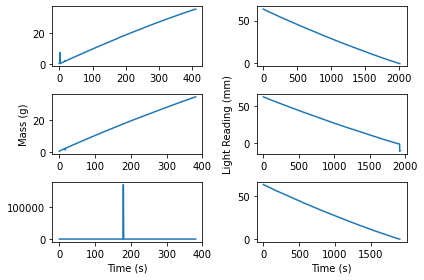

In [6]:
#Read sensor data
fig, axs = plt.subplots(3,2)

#axs[0,0].plot(time_30_light_measured1,csv_data_30_light_measured1)
axs[0,0].plot(csv_data_30_light_measured1)
axs[0,1].plot(time_30_light1,csv_data_30_light1)

#axs[1,0].plot(time_30_light_measured2,csv_data_30_light_measured2)
axs[1,0].plot(csv_data_30_light_measured2)

axs[1,0].set_ylabel('Mass (g)')
axs[1,1].plot(time_30_light2,csv_data_30_light2)
axs[1,1].set_ylabel('Light Reading (mm)')

#axs[2,0].plot(time_30_light_measured3,csv_data_30_light_measured3)
axs[2,0].plot(csv_data_30_light_measured3)
axs[2,1].plot(time_30_light3,csv_data_30_light3)
axs[2,0].set_xlabel('Time (s)')
axs[2,1].set_xlabel('Time (s)')

(0.0, 2.0)

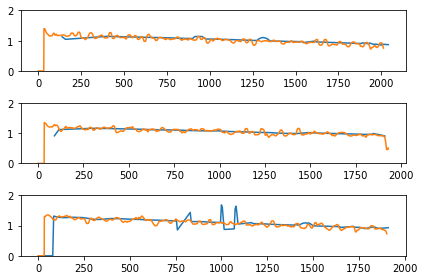

In [7]:
fig, axs_2 = plt.subplots(3)
flow_rate_light1 = get_rolling_slope(csv_data_30_light1)
flow_rate_light2 = get_rolling_slope(csv_data_30_light2)
flow_rate_light3 = get_rolling_slope(csv_data_30_light3)

flow_rate_light_measured1,time_light_measured1_filt =get_rolling_slope_measured(csv_data_30_light_measured1,time_30_light_measured1)
flow_rate_light_measured2,time_light_measured2_filt =get_rolling_slope_measured(csv_data_30_light_measured2,time_30_light_measured2)
flow_rate_light_measured3,time_light_measured3_filt =get_rolling_slope_measured(csv_data_30_light_measured3,time_30_light_measured3)

load_scaling_factor = 1  # 0.54 #0.45
y_lim = [0,2]
axs_2[0].plot(time_light_measured1_filt,flow_rate_light_measured1)
# axs_2[0].plot(time_30_light1,np.multiply(multiply_factor,flow_rate_light1))
axs_2[0].plot(time_30_light1, flow_rate_light1)
axs_2[0].set_ylim(y_lim)

axs_2[1].plot(time_light_measured2_filt,flow_rate_light_measured2)
# axs_2[1].plot(time_30_light2,np.multiply(multiply_factor,flow_rate_light2))  # time_light2
axs_2[1].plot(time_30_light2, flow_rate_light2)  # time_light2
axs_2[1].set_ylim(y_lim)

axs_2[2].plot(time_light_measured3_filt,flow_rate_light_measured3)
# axs_2[2].plot(time_30_light3,np.multiply(multiply_factor,flow_rate_light3)) # time_light3
axs_2[2].plot(time_30_light3, flow_rate_light3) # time_light3
axs_2[2].set_ylim(y_lim)

In [8]:
# resample scale/measured data

# ========================
# GET MSE
# ========================
final_measured_1 = resample(flow_rate_light_measured1, len(flow_rate_light1))[225:1800]
final_measured_2 = resample(flow_rate_light_measured2, len(flow_rate_light2))[225:1800]
final_measured_3 = resample(flow_rate_light_measured3, len(flow_rate_light3))[225:1800]
final_measured_1 = np.around(final_measured_1, decimals=2)
final_measured_2 = np.around(final_measured_2, decimals=2)
final_measured_3 = np.around(final_measured_3, decimals=2)

# final_sensor_1 = [val*load_scaling_factor for val in flow_rate_light1][225:1800]
# final_sensor_2 = [val*load_scaling_factor for val in flow_rate_light2][225:1800]
# final_sensor_3 = [val*load_scaling_factor for val in flow_rate_light3][225:1800]
final_sensor_1 = flow_rate_light1[225:1800]
final_sensor_2 = flow_rate_light2[225:1800]
final_sensor_3 = flow_rate_light3[225:1800]
# print(flow_rate_light1)
final_sensor_1 = np.around(final_sensor_1, decimals=2)
final_sensor_2 = np.around(final_sensor_2, decimals=2)
final_sensor_3 = np.around(final_sensor_3, decimals=2)

# calculate MSE
mse1 = mean_squared_error(final_measured_1, final_sensor_1)
mse2 = mean_squared_error(final_measured_2, final_sensor_2)
mse3 = mean_squared_error(final_measured_3, final_sensor_3)

print(f'MSE values: {mse1}, {mse2}, {mse3}')
print(f'Average MSE: {np.mean([mse1, mse2, mse3])}')
max_diff_1 = max(abs(final_measured_1-final_sensor_1))
max_diff_2 = max(abs(final_measured_2-final_sensor_2))
max_diff_3 = max(abs(final_measured_3-final_sensor_3))

print(f'Max diff: {max_diff_1}, {max_diff_2}, {max_diff_3}')

MSE values: 0.00319269841269841, 0.002923619047619046, 0.013360825396825394
Average MSE: 0.00649238095238095
Max diff: 0.16999999999999993, 0.1399999999999999, 0.73


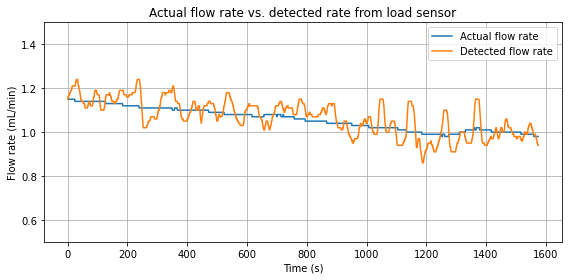

In [13]:
# y_lim = [0,2]
y_lim = [0.5, 1.5]

plt.figure(figsize=(8, 4))
plt.title('Actual flow rate vs. detected rate from load sensor')
# plt.plot(time_light_measured2_filt,flow_rate_light_measured2)
# # axs_2[1].plot(time_30_light2,np.multiply(multiply_factor,flow_rate_light2))  # time_light2
# plt.plot(time_30_light2, flow_rate_light2)  # time_light2

plt.plot(final_measured_2, label='Actual flow rate')
plt.plot(final_sensor_2, label='Detected flow rate')
plt.ylim(y_lim)
plt.xlabel('Time (s)')
plt.ylabel('Flow rate (mL/min)')
plt.legend()
plt.grid()


# plt.subplot(311)
# plt.plot(final_measured_1, label='measured (scale)')
# plt.plot(final_sensor_1, label='load sensor')
# plt.ylim(y_lim)
# plt.legend()
# plt.grid()
# plt.title(csv_name_30_light1)

# plt.subplot(312)
# plt.plot(final_measured_2, label='measured (scale)')
# plt.plot(final_sensor_2, label='load sensor')
# plt.ylim(y_lim)
# plt.legend()
# plt.grid()
# plt.title(csv_name_30_light2)

# plt.subplot(313)
# plt.plot(final_measured_3, label='measured (scale)')
# plt.plot(final_sensor_3, label='load sensor')
# plt.ylim(y_lim)
# # plt.xlabel('Time (s)')
# plt.legend()
# plt.grid()
# plt.title(csv_name_30_light3)

# plt.tight_layout()
plt.show()